In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras.models import Model
from keras.losses import binary_crossentropy
import warnings
warnings.filterwarnings('ignore')
np.random.seed(25)
tf.executing_eagerly()

Getting the data

In [ ]:
labels_path = '/content/drive/MyDrive/dog-breed-identification/labels.csv'

labels_df = pd.read_csv(labels_path)

#Selecting only the 30 most frequent breeds

breeds30 = sorted(list(labels_df['breed'].value_counts().head(30).index))

train_df = labels_df[labels_df['breed'].isin(breeds30)]


breeds30

['afghan_hound',
 'airedale',
 'australian_terrier',
 'basenji',
 'beagle',
 'bernese_mountain_dog',
 'blenheim_spaniel',
 'cairn',
 'chow',
 'entlebucher',
 'great_pyrenees',
 'irish_wolfhound',
 'italian_greyhound',
 'japanese_spaniel',
 'lakeland_terrier',
 'leonberg',
 'maltese_dog',
 'miniature_pinscher',
 'norwegian_elkhound',
 'papillon',
 'pembroke',
 'pomeranian',
 'pug',
 'saluki',
 'samoyed',
 'scottish_deerhound',
 'shih-tzu',
 'siberian_husky',
 'tibetan_terrier',
 'whippet']

Generating train dataset

In [ ]:

train_path = "/content/drive/MyDrive/dog-breed-identification/train/"
test_path = "/content/drive/MyDrive/dog-breed-identification/test/"

img_dim = 64


train_df['image_path'] = train_df.apply(lambda x: (train_path + x["id"] + ".jpg" ), axis=1 )
train_data = np.array([ img_to_array(load_img(img, target_size=(img_dim, img_dim))) for img in train_df['image_path'].values.tolist()]).astype('float32')
train_labels = train_df['breed']

X_train = train_data/255
y_train = train_labels

print(X_train.shape)
print(y_train.shape)

(3134, 64, 64, 3)
(3134,)


In [ ]:
img_height   = X_train.shape[1]   
img_width    = X_train.shape[2]    
num_channels = X_train.shape[3]    
input_shape =  (img_height, img_width, num_channels)   
latent_dim = 150

Encoder Architecture

In [ ]:
encoder_input = Input(shape=input_shape)

encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)

encoder_conv = Conv2D(filters=32, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)

encoder_conv = Conv2D(filters=64, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)

encoder_conv = Conv2D(filters=128, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)

encoder_conv = Conv2D(filters=256, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)

encoder_conv = Conv2D(filters=512, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)



encoder = Flatten()(encoder_conv)

mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

def compute_latent(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

latent_space = Lambda(compute_latent, output_shape=(latent_dim,))([mu, sigma])
conv_shape = K.int_shape(encoder_conv)

Decoder Architecture

In [ ]:
decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)

decoder_conv = Conv2DTranspose(filters=512, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=256, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=128, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3, 
                          padding='same', activation='sigmoid')(decoder_conv)

Creating the Model

In [ ]:
encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)

vae = Model(encoder_input, decoder(encoder(encoder_input)))

Loss Function and Compiling

In [ ]:
def kl_reconstruction_loss(true, pred):
  # Reconstruction loss
  reconstruction_loss = K.sum(K.square(true-pred), axis=[1,2,3])
  # KL divergence loss
  kl_loss = - 0.5 * K.sum(1 + 2*sigma - K.square(mu) - K.square(K.exp(sigma)), axis=-1)
  return  reconstruction_loss + 1*kl_loss


vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

Training

In [ ]:
history = vae.fit(x=X_train, y=X_train, epochs=50, batch_size=32, validation_data=(X_train,X_train))

Train on 3134 samples, validate on 3134 samples
Epoch 1/50
3134/3134 [==============================] - 14s 5ms/sample - loss: 40474047119.6228 - val_loss: 729.3506
Epoch 2/50
3134/3134 [==============================] - 12s 4ms/sample - loss: 660.9877 - val_loss: 567.0690
Epoch 3/50
3134/3134 [==============================] - 12s 4ms/sample - loss: 535.3379 - val_loss: 508.8769
Epoch 4/50
3134/3134 [==============================] - 12s 4ms/sample - loss: 497.2065 - val_loss: 477.0922
Epoch 5/50
3134/3134 [==============================] - 12s 4ms/sample - loss: 476.0460 - val_loss: 463.9706
Epoch 6/50
3134/3134 [==============================] - 12s 4ms/sample - loss: 459.6881 - val_loss: 449.8652
Epoch 7/50
3134/3134 [==============================] - 12s 4ms/sample - loss: 447.9122 - val_loss: 439.1561
Epoch 8/50
3134/3134 [==============================] - 12s 4ms/sample - loss: 438.2034 - val_loss: 428.7947
Epoch 9/50
3134/3134 [==============================] - 12s 4ms/sample -

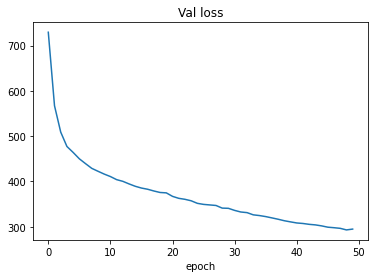

In [ ]:
plt.plot(history.history['val_loss'])
plt.title("Val loss")
plt.xlabel('epoch')
plt.show()

Predicting Images

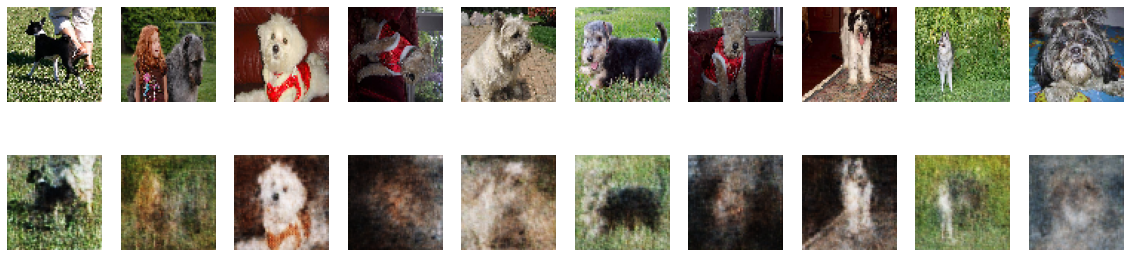

In [ ]:
plt.figure(figsize=(20,5))
X_pred = vae.predict(X_train[:10])

for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(X_train[i])
    plt.axis('off')

for i in range(10):
    plt.subplot(2,10,10+i+1)
    plt.imshow(X_pred[i])
    plt.axis('off')

  Generating random images utilizing decoder

In [ ]:
encoded = encoder.predict(X_train)
encoded.shape

#shape is n_of_samples x latent_dim

(3134, 150)

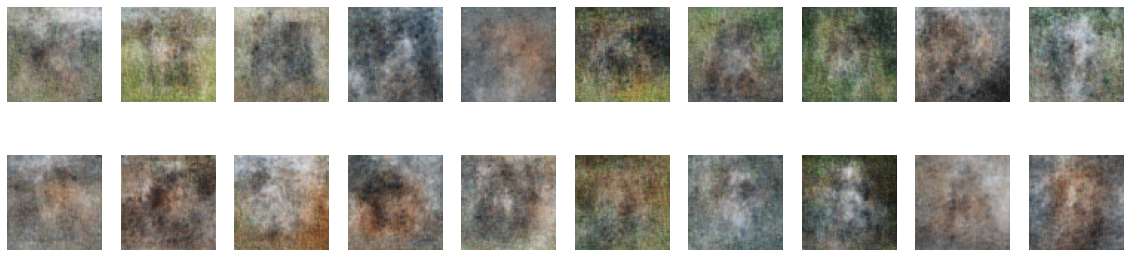

In [ ]:
rand_data = np.random.normal(size = 20 * latent_dim).reshape(-1, latent_dim)
new_images = decoder.predict(rand_data)

plt.figure(figsize=(20,5))
for i, dog in enumerate(new_images):
    plt.subplot(2,10,i+1)
    plt.imshow(dog)
    plt.axis('off')